# Recreating Stockhammar & Oller (2007)
This notebook repropduces the workflow in Stockhammar & Oller's 2007 paper "A Simple Heteroscedasticity Removing Filter." The data was located on the website of the Bureau of Economic Analysis, bea.gov, and limited to the time window used in the study. Python functions are constucted to encompass the filtering methods described in the paper, with some additional flexibility. These functions are then used in the project notebooks to test them on the project data, and see if the filtering of heteroscedasticity before modeling is beneficial to coefficient efficiency and forecasting.

In [2]:
# Importing the necessary libraries
from arch import arch_model
from functions import tsa
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# Allows you to import r packages
from rpy2.robjects.packages import importr
# Allows for calling r function in python
from rpy2.robjects import r
# Will convert python lists to a R style FloatVector
from rpy2.robjects import FloatVector

In [4]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

In [5]:
# Plot styling
plt.style.use('ggplot')
from jupyterthemes import jtplot
jtplot.style()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 7

In [6]:
pd.plotting.register_matplotlib_converters()

In [7]:
# Import desired R package(s)
importr('forecast')

rpy2.robjects.packages.Package as a <module 'forecast'>

In [11]:
usgdp = pd.read_csv('data/GDP.csv')
usgdp.head()

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [12]:
usgdp.DATE = pd.to_datetime(usgdp.DATE)
usgdp.set_index('DATE', inplace=True)

In [13]:
usgdp = usgdp['1947-01-01':'2006-01-01']
usgdp

,GDP
DATE,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
...,...
2005-01-01,12761.337
2005-04-01,12910.022
2005-07-01,13142.873


In [14]:
lngdp = np.log(usgdp)
diff_ln = lngdp.diff()
diff_ln.head()

,GDP
DATE,
1947-01-01,NaN
1947-04-01,0.011465
1947-07-01,0.014598
1947-10-01,0.039901
1948-01-01,0.022826


In [15]:
lngdp.GDP.mean()

7.553331637421791

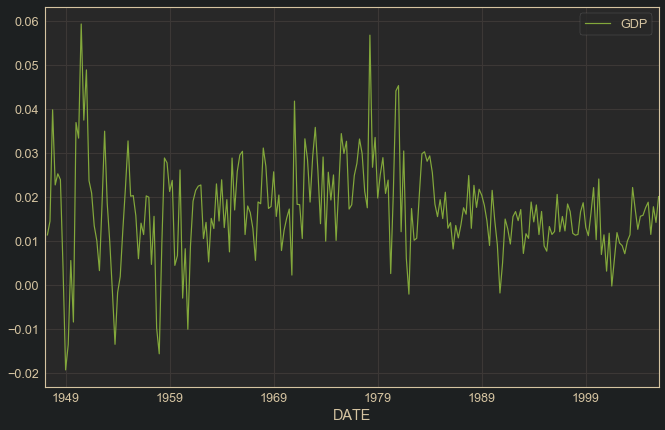

In [16]:
diff_ln.plot()

In [17]:
def so_filter(series, sd_method='rolling', l=None, k=0, lamb=700, center=True, visualize=False,
                hp_filter=True, return_df=False, d=1):
    '''Takes in a pandas series and filters it to become stationary according to the process
    outlined by Stockhammar & Oller (2007). Series passed should be the already differenced
    series (close to stationary but with local trends and heteroscedasticity).
    '''
    
    series_mean = series.mean()
    
    if k > 0:
        rolling_means = series.rolling(window=k, center=center).mean()
        mean_filt = series - rolling_means
        rolling_means.name = 'ma'
    else:
        mean_filt = series - series_mean
    
    # Get local stds using Stockhammer & Oller (2007) method
    if sd_method == 'rolling':
        stds = series.rolling(window=l, center=center).std(ddof=1).dropna()
    
    # Get local stds using GARCH
    if sd_method == 'GARCH':
        arch = arch_model(mean_filt, 
                      mean='Zero', 
                      vol='GARCH', 
                      #dist='t'
                      rescale=True
                     ).fit()
        stds = arch.conditional_volatility / arch.scale
        print(arch.summary())
    
    # Perform filtering

    if hp_filter:
        stds = pd.DataFrame(hpfilter(stds, lamb=lamb)).T.iloc[:, 1]
        
    stds.name = 'sd'
    
    filtered = series.std() * ((mean_filt) / stds) + series_mean
    filtered = filtered.dropna()
    filtered.name = 'filtered_series'
    
    if visualize:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(11,10), sharex=True)
        series.plot(label=series.name, ax=ax1)
        stds.plot(label='local SD', ax=ax1)
        ax1.set_title('Series with local SD')
        ax1.legend()
        filtered.plot(label=series.name, ax=ax2)
        ax2.set_title('Filtered Series')
        ax2.legend()
        plt.tight_layout()
        plt.show()
        
    results = pd.merge(filtered, stds, left_index=True, right_index=True)
    if k > 0:
        results = pd.merge(results, rolling_means, left_index=True, right_index=True)
    
    if return_df:
        return results
    else:
        return filtered

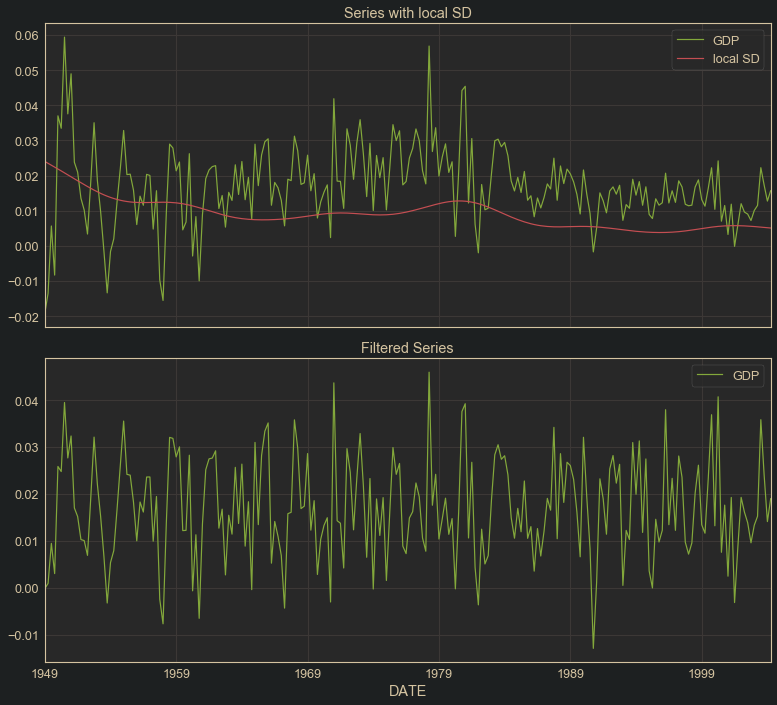

In [18]:
# Applying the complete filtering process to the data with the parameters used in the study
filtered = so_filter(diff_ln.GDP, sd_method='rolling', l=15, k=15, lamb=1600, visualize=True,
                     return_df = True
                    )

We can see that the filtering function, using the parameters from the study, has worked as expected. This could come in handy for future time series datasets. We will use this in the modeling notebook to see if it can help models with their predictive accuracy.

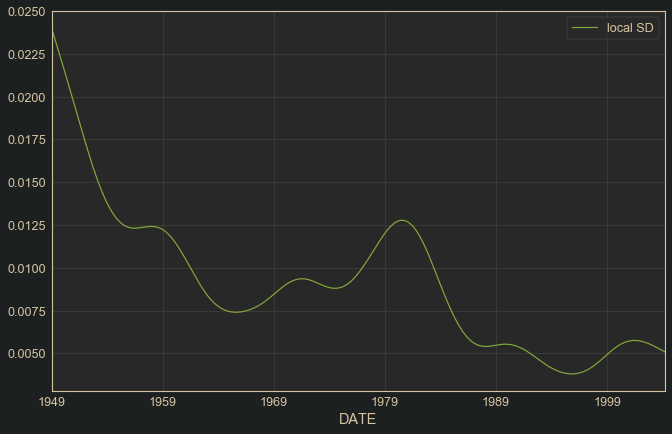

In [19]:
# Looking at the local standard deviations used in the filtering process
filtered.sd.plot()
plt.legend(['local SD'])

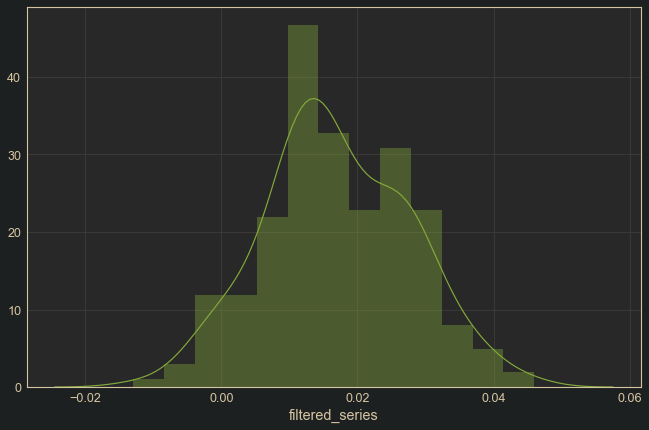

In [20]:
sns.distplot(filtered.filtered_series)

In [21]:
def mean_filter(series, k, method='SO', center=False, return_means=False):
    if method == 'pd':
        means = series.rolling(window=k, center=center).mean()
        filtered = series - means
        filtered.name = series.name
        
    # Stockhammar & Oller's method (SO) - basically the same as non-centered pd method but k=1 
    # has special behavior of performing another order of differencing.
    if method == 'SO':
        if k % 2 == 0:
            raise ValueError('k must be odd number')
        n = series.index
        eta = int((k-1)/2)

        filtered = pd.Series(name=series.name)
        means = pd.Series(name='localMeans')

        for t in range(eta, len(n)-eta):
            if eta > 0:
                window = [series.iloc[i] for i in range(t-eta, t+eta+1)]
                term = np.mean(window)
            else:
                if t == 0:
                    term = np.NaN
                else:
                    term = series.iloc[t-1]

            filtered.loc[n[t]] = series.iloc[t] - term
            means.loc[n[t]] = term
    
    filtered = filtered.dropna()
    
    if return_means:
        return filtered, means
    else:
        return filtered

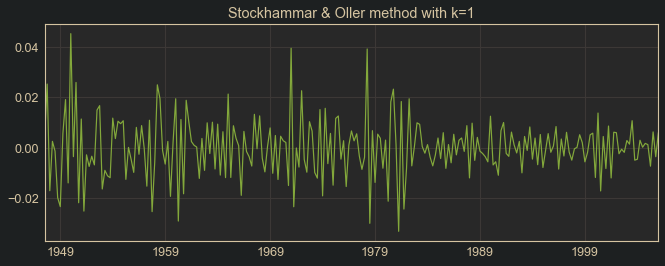

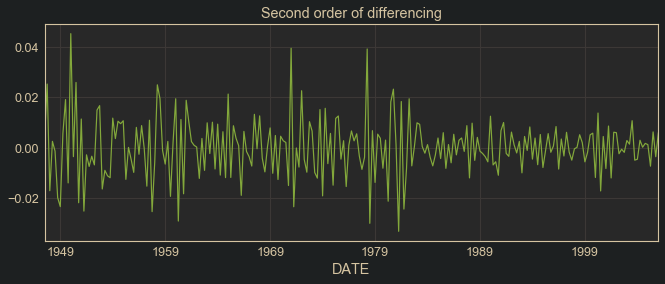

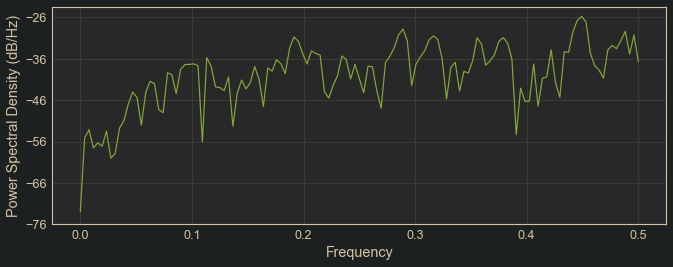

In [22]:
# When using Stockhammar and Oller's method, k=1 should perform another order of difference:
mean_filt = mean_filter(diff_ln.GDP, method='SO', k=1)
mean_filt.plot(figsize=(11,4))
plt.title('Stockhammar & Oller method with k=1')
plt.show()
diff_ln.GDP.diff().dropna().plot(figsize=(11,4))
plt.title('Second order of differencing')
plt.show()
plt.figure(figsize=(11,4))
plt.psd(mean_filt, Fs=1);

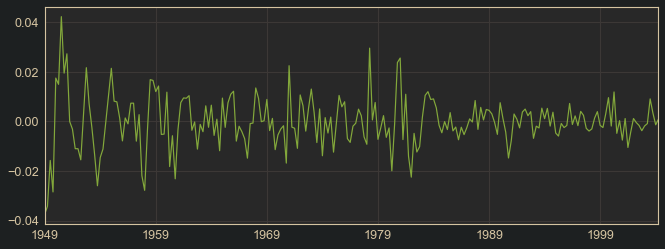

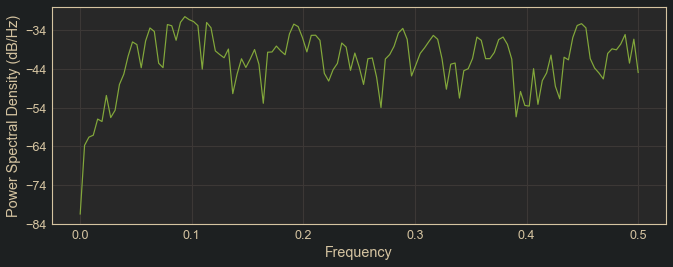

In [23]:
# We can see that the above has worked as expected, let's see their recommended k values of 15:
mean_filt = mean_filter(diff_ln.GDP, method='SO', k=15)
mean_filt.plot(figsize=(11,4))
plt.show()
plt.figure(figsize=(11,4))
plt.psd(mean_filt, Fs=1);

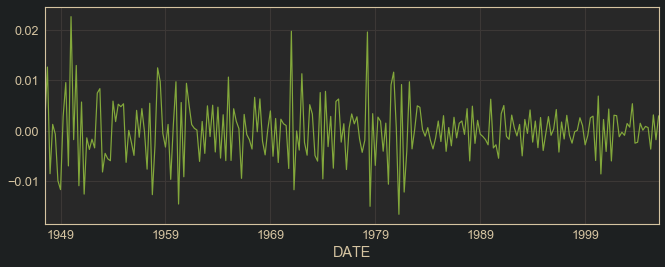

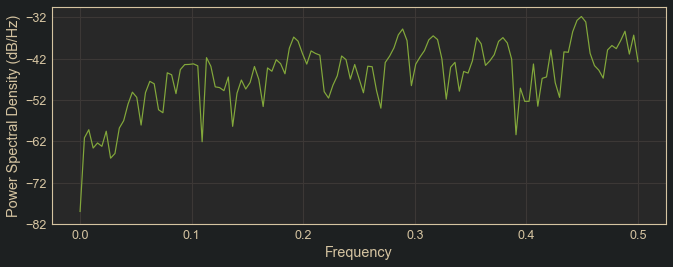

In [24]:
# The problem with trying to use the SO method of mean filtering is that it uses future data
# to generate local means, using a centered window for all k values > 1. This would make it 
# difficult to transform the series back to returns after modeling for prediction. Instead,
# using pandas method of rolling means with a non-centered window will allow us an easier road
# to reverse transformation
mean_filt, loc_means = mean_filter(diff_ln.GDP, method='pd', k=2, return_means=True)
mean_filt.plot(figsize=(11,4))
plt.show()
plt.figure(figsize=(11,4))
plt.psd(mean_filt, Fs=1);

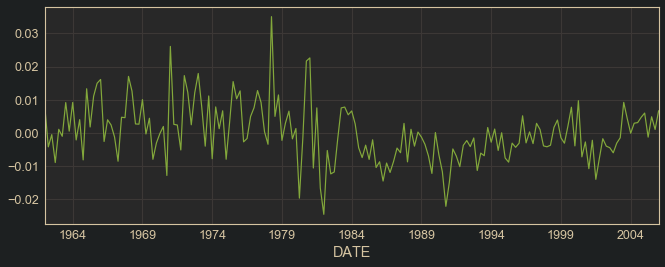

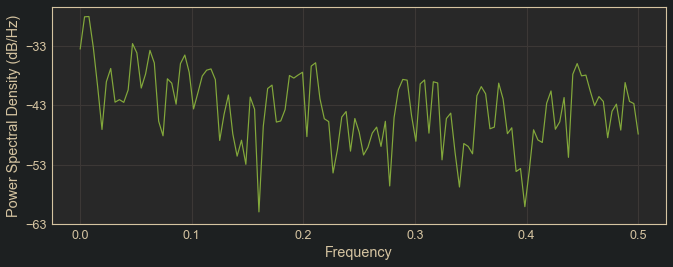

In [25]:
# This has successfully removed local trends
# We can see that using a window length of 2 has produced a similar patter to second order
# differencing, but with a smaller magnitude. Let's see if larger window sizes smooth this
mean_filt, loc_means = mean_filter(diff_ln.GDP, method='pd', k=60, return_means=True)
mean_filt.plot(figsize=(11,4))
plt.show()
plt.figure(figsize=(11,4))
plt.psd(mean_filt, Fs=1);

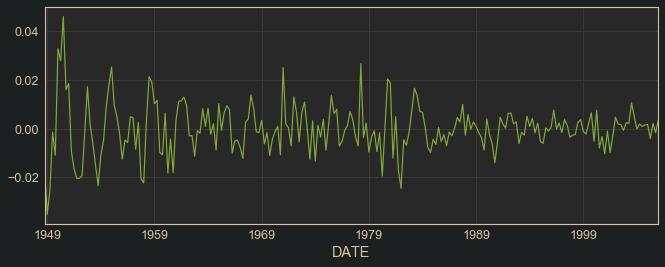

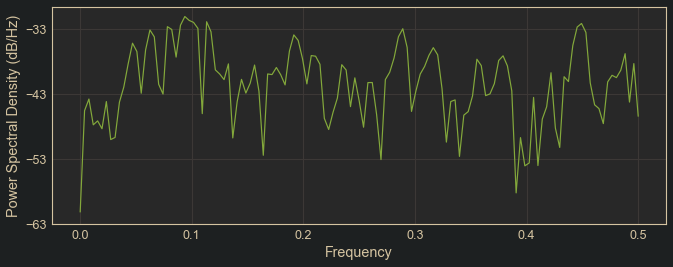

In [26]:
# We can see that the larger the window, the smoother the resulting data.
# We can also see that the window size is acting as a low pass filter, which is quieting
# higher frequency noise as it gets larger.
# Let's go in the middle ground, with a window size of 7
mean_filt, loc_means = mean_filter(diff_ln.GDP, method='pd', k=7, return_means=True)
mean_filt.plot(figsize=(11,4))
plt.show()
plt.figure(figsize=(11,4))
plt.psd(mean_filt, Fs=1);

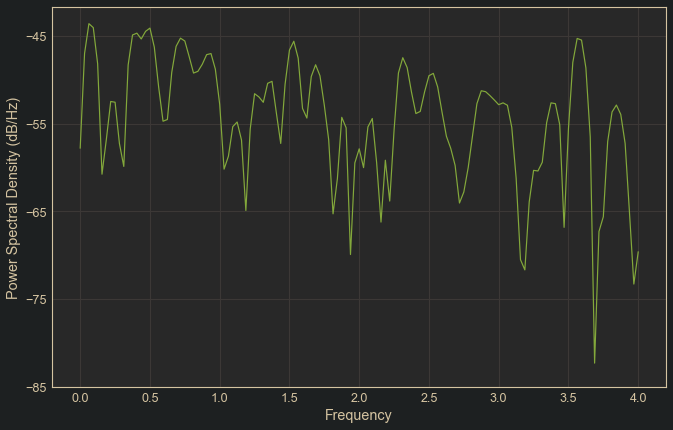

In [27]:
# Let's see more of the low pass filtering in action, with a larger k value
mean_filt = mean_filter(diff_ln['GDP'], method='SO', k=117)
plt.psd(mean_filt, Fs=8);

## Applying to data from project

In [31]:
means = pd.read_csv('data/housing_means2.csv').rename(columns={'Unnamed: 0': 'date'})
means.set_index('date', inplace=True)
means.head()

,mean price
date,
1996-04-01,11.514264
1996-05-01,11.515620
1996-06-01,11.516949
1996-07-01,11.518236
1996-08-01,11.519576


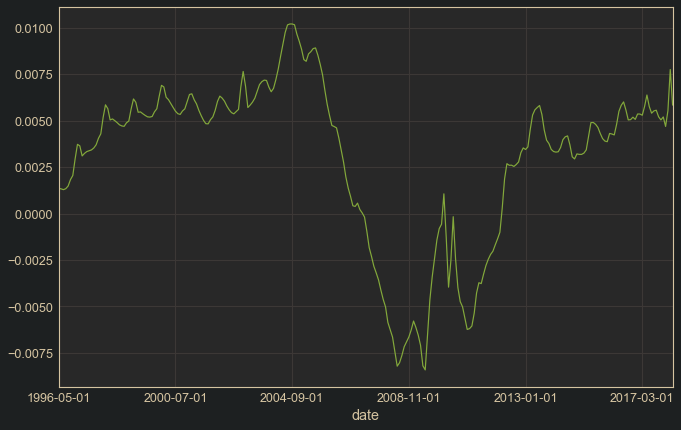

In [38]:
log_returns = means['mean price'].diff().dropna()
log_returns.name = 'log_returns'
log_returns.plot()

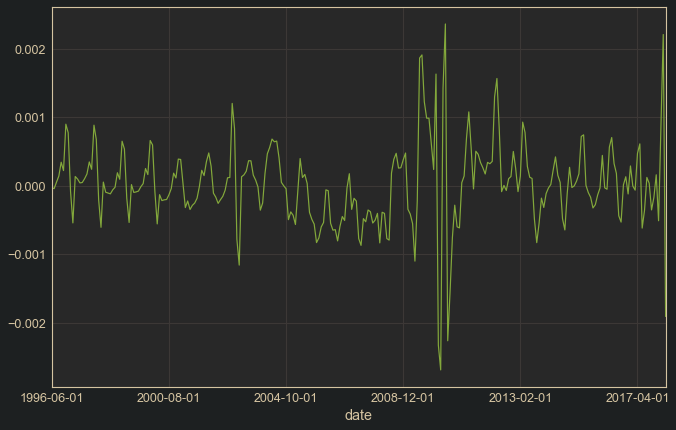

In [39]:
diff_returns = log_returns.diff().dropna()
diff_returns.plot()

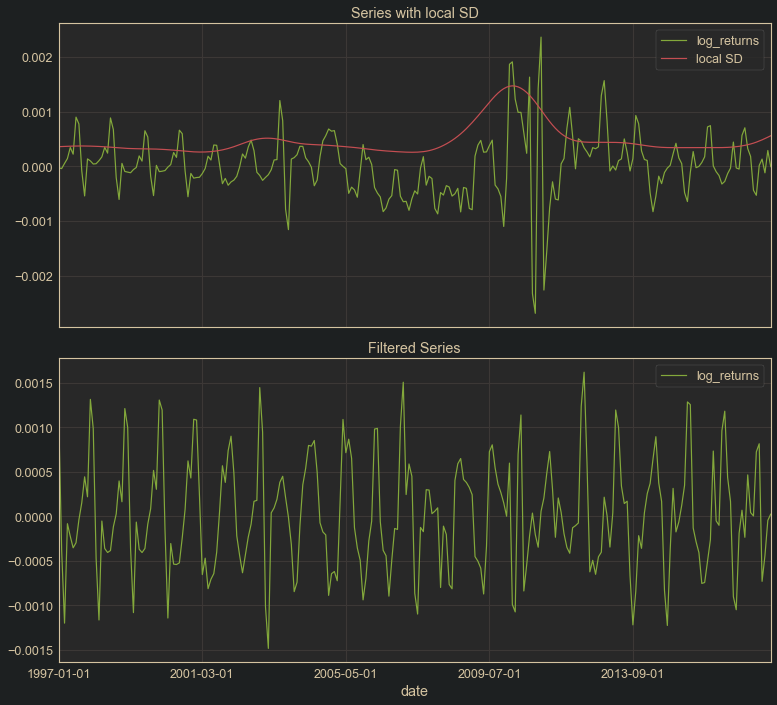

In [40]:
filtered = so_filter(diff_returns, l=15, k=15, visualize=True)

In [41]:
print('Variance of unfiltered series:', diff_returns.var())
print('Variance of filtered series:', filtered.var())

Variance of unfiltered series: 3.7378429472040784e-07
Variance of filtered series: 3.8360430577569723e-07


In [ ]:
# We can see that the overall variance has not been affected much. Let's see what happens to
# a SARIMAX model fit to the unfiltered vs filtered data
